In [41]:
import torch
from PIL import Image
print(torch.__version__)
print(torch.cuda.is_available())

img = Image.open('mnist_train_torch/0/00000.png')

display(img)

2.8.0+cu126
True


torch.Size([1, 128, 128])


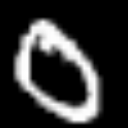

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

In [42]:
import torch
import torchvision.transforms as T

class Config:
    backbone = 'resnet153' # [timm]
    metric = 'arcface' # ['arcface', 'cosface]
    embedding_size = 512
    input_shape = [1, 128, 128]
    train_transform = T.Compose([ 
        T.Grayscale(num_output_channels=1),
        T.RandomHorizontalFlip(p=0.5),
        T.Resize((144, 144)),
        T.RandomCrop(input_shape[1:]),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5]) 
        # 需要注意的是，这个 mean 指的是均值减去 0.5 并不是把当前的像素点的均值变成 0.5，
        # 也就是默认了现在的均值为 0.5，标准差为 0.5，转化为了均值为 0，标准差为 1 的一般形式
    ])
    test_transforme = T.Compose([
        T.Grayscale(num_output_channels=1),
        T.Resize(input_shape[1:]),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])
    ])
    train_root = "./mnist_train_torch"
    test_root = "./lfw-align-128"
    test_list = "./lfw_test_pair.txt"
    checkpoints = "checkpoints"
    test_model = "checkpoints/0.pth"
    train_batch_size = 64
    test_batch_size = 64
    epochs = 10
    optimizer = "sgd" # ['sgd', 'adam']
    lr = 1e-1
    lr_step = 10
    lr_decay = 0.95
    weight_decay = 5e-4
    loss = "focal_loss" # ['focal_loss', 'cross_entropy']
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    pin_memory = True
    num_workers = 4
config = Config()

# 展示经过 train_transform 转化之后的图片
show_img = ((config.train_transform(img)) * 0.5 + 0.5).clamp(0, 1)
print(show_img.shape)
to_image = T.ToPILImage()
display(to_image(show_img))

display(config.train_transform(img))
    

In [43]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

def load_data(conf, training = True):
    if training:
        data_root = conf.train_root
        transform = conf.train_transform
        batch_size = conf.train_batch_size
    else:
        data_root = conf.test_root
        transform = conf.test_transform
        batch_size = conf.test_batch_size
    data = ImageFolder(data_root, transform=transform)
    class_num = len(data.classes)
    loader = DataLoader(data, batch_size=batch_size, shuffle=True, pin_memory=conf.pin_memory, num_workers=conf.num_workers)
    return loader, class_num

loader, class_num = load_data(config, True)

print(class_num)

10


In [44]:
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
class ConvBn(nn.Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=1, padding=0, groups=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_c)
        )
    def forward(self, x):
        return self.net(x)

class ConvBnPrelu(nn.Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=1, padding=0, groups=1):
        super().__init__()
        self.net = nn.Sequential(
            ConvBn(in_c, out_c, kernel, stride, padding, groups),
            nn.PReLU(out_c)
        )
    def forward(self, x):
        return self.net(x)

class DepthWise(nn.Module):
    def __init__(self, in_c, out_c, kernel=(3, 3), stride=2, padding=0, groups=1):
        super().__init__()
        self.net = nn.Sequential(
            ConvBnPrelu(in_c, groups, kernel=(1, 1), stride=1, padding=0),
            ConvBnPrelu(groups, groups, kernel=kernel, stride=stride, padding=padding, groups=groups),
            ConvBn(groups, out_c, kernel=(1, 1), stride=1, padding=0)
        )
    def forward(self, x):
        return self.net(x)

class DepthWiseRes(nn.Module):
    def __init__(self, in_c, out_c, kernel=(3, 3), stride=2, padding=2, groups=1):
        super().__init__()
        self.net = DepthWise(in_c, out_c, kernel, stride, padding, groups)
    def forward(self, x):
        return self.net(x) + x
    
class MultiDepthWiseRes(nn.Module):
    def __init__(self, num_block, channels, kernel=(3, 3), stride=1, padding=1, groups=1):
        super().__init__()
        self.net = nn.Sequential(*[ # 解包把列表展开传给 Sequential
            DepthWiseRes(channels, channels, kernel, stride, padding, groups)
            for _ in range(num_block)
        ])
    def forward(self, x):
        return self.net(x)


In [45]:
class FaceMobileNet(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        self.conv1 = ConvBnPrelu(1, 64, kernel=(3, 3), stride=2, padding=1)
        self.conv2 = ConvBn(64, 64, kernel=(3, 3), stride=1, padding=1, groups=64)
        self.conv3 = DepthWise(64, 64, kernel=(3, 3), stride=2, padding=1, groups=128)
        self.conv4 = MultiDepthWiseRes(num_block=4, channels=64, kernel=3, stride=1, padding=1, groups=128)
        self.conv5 = DepthWise(64, 128, kernel=(3, 3), stride=2, padding=1, groups=256)
        self.conv6 = MultiDepthWiseRes(num_block=6, channels=128, kernel=(3, 3), stride=1, padding=1, groups=256)
        self.conv7 = DepthWise(128, 128, kernel=(3, 3), stride=2, padding=1, groups=512)
        self.conv8 = MultiDepthWiseRes(num_block=2, channels=128, kernel=(3, 3), stride=1, padding=1, groups=256)
        self.conv9 = ConvBnPrelu(128, 512, kernel=(1, 1))
        self.conv10 = ConvBn(512, 512, groups=512, kernel=(7, 7))
        self.flatten = Flatten()
        self.linear = nn.Linear(2048, embedding_size, bias=False)
        self.bn = nn.BatchNorm1d(embedding_size)
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.conv9(out)
        out = self.conv10(out)
        out = self.flatten(out)
        out = self.linear(out)
        out = self.bn(out)
        return out

In [46]:
import torch
import torch.nn as nn
class FocalLoss(nn.Module):

    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = torch.nn.CrossEntropyLoss()
    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [47]:
import torch.nn as nn
import torch.nn.functional as F
class CosFace(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.40):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        output = cosine * 1.0
        batch_size = len(output)
        output[range(batch_size), label] = phi[range(batch_size), label]
        return output * self.s

In [48]:
import torch.optim as optim
from tqdm import tqdm

if __name__ == '__main__':
    dataloader, class_num = load_data(config, training=True)
    device = config.device
    embedding_size = config.embedding_size
    net = FaceMobileNet(embedding_size).to(device)
    metric = CosFace(embedding_size, class_num).to(device)
    criterion = FocalLoss(gamma=2)
    optimizer = optim.SGD(
        list(net.parameters()) + list(metric.parameters()),
        lr=config.lr,
        weight_decay=config.weight_decay
    )
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.lr_step, gamma=0.1)
    net.train()
    for e in range(config.epochs):
        total_loss = 0
        for data, labels in tqdm(dataloader, desc=f"Epoch {e+1}/{config.epochs}", ascii=True):
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = net(data)
            thetas = metric(embeddings, labels)
            loss = criterion(thetas, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {e+1}/{config.epochs}, Loss: {avg_loss:.4f}")
        torch.save(net.state_dict(), f"checkpoint_epoch_{e+1}.pth")
        scheduler.step()

Epoch 1/10: 100%|##########| 938/938 [02:17<00:00,  6.82it/s]


Epoch 1/10, Loss: 1.5279


Epoch 2/10: 100%|##########| 938/938 [00:49<00:00, 18.93it/s]


Epoch 2/10, Loss: 0.2891


Epoch 3/10: 100%|##########| 938/938 [01:06<00:00, 14.09it/s]


Epoch 3/10, Loss: 0.2029


Epoch 4/10: 100%|##########| 938/938 [01:55<00:00,  8.09it/s]


Epoch 4/10, Loss: 0.1633


Epoch 5/10: 100%|##########| 938/938 [00:54<00:00, 17.16it/s]


Epoch 5/10, Loss: 0.1454


Epoch 6/10: 100%|##########| 938/938 [01:12<00:00, 13.02it/s]


Epoch 6/10, Loss: 0.1378


Epoch 7/10: 100%|##########| 938/938 [01:39<00:00,  9.43it/s]


Epoch 7/10, Loss: 0.1235


Epoch 8/10: 100%|##########| 938/938 [00:52<00:00, 17.98it/s]


Epoch 8/10, Loss: 0.1172


Epoch 9/10: 100%|##########| 938/938 [00:52<00:00, 17.78it/s]


Epoch 9/10, Loss: 0.1031


Epoch 10/10: 100%|##########| 938/938 [00:51<00:00, 18.36it/s]

Epoch 10/10, Loss: 0.1068
